Ce code permet d'automatiser le rapport sur le prix au m². 

Les objets à mettre dans le rapport sont marqués par # TODO en début de cellule. (Il faut exécuter la cellule puis insérer au Latex ce qui est indiqué dans TODO)

Le code est organisé de la même manière que le rapport, les titres sont écrits dans des cellules Markdown

Executer sur l'environnement base

### A faire par l'utilisateur :
- Télécharger les données de l'INSEE pour les appartements (à part pour Lille les maisons)
- Les données à télécharger sont : Départements d'IDF (hors Paris), Province, Régions disponibles, Villes (Paris, Marseille, Lyon, Lille)
- Les tables doivent être enregistrées en csv (;) au chemin N:\uflujek\table_rapport\Indice_prix avec les noms suivant :
- - valeurs_trimestrielles_APT_77, valeurs_trimestrielles_APT_78, valeurs_trimestrielles_APT_91, valeurs_trimestrielles_APT_92, valeurs_trimestrielles_APT_93, valeurs_trimestrielles_APT_94, valeurs_trimestrielles_APT_95
- - valeurs_trimestrielles_province
- - valeurs_trimestrielles_APT_PARIS, valeurs_trimestrielles_APT_MARSEILLE, valeurs_trimestrielles_APT_LYON, valeurs_trimestrielles_MAI_LILLE
- - valeurs_trimestrielles_Nord-Pas-de-Calais, valeurs_trimestrielles_Provence-Alpes-Côte-d'Azur, valeurs_trimestrielles_Rhône-Alpes

In [18]:
regions_interested = ["Nord-Pas-de-Calais", "Provence-Alpes-Côte-d'Azur", 'Rhône-Alpes'] # A changer si les régions de l'INSEE changent
villes = ["PARIS", "MARSEILLE", "LYON", "LILLE"]# A changer si les villes de l'INSEE changent
# Liste correspondante des types de biens pour les villes 
types_biens = ["APT", "APT", 'APT', 'MAI']

In [19]:
########################################## IMPORT ##########################################
import os
import pandas as pd
import time
import numpy as np
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xlsxwriter

from io import BytesIO

from datetime import datetime
import string
import openpyxl
import pandasql as ps
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from openpyxl.styles.differential import DifferentialStyle
from openpyxl.formatting.rule import Rule
from openpyxl.utils import get_column_letter
from openpyxl.utils.dataframe import dataframe_to_rows
import shutil
from openpyxl.drawing.image import Image
from openpyxl.styles import Font, Color, PatternFill, Border, Side
from openpyxl.utils.cell import coordinate_from_string, column_index_from_string
import warnings
import pathlib
import pyodbc
warnings.filterwarnings('ignore')
sns.set_theme()

In [20]:
SERVEUR = 'ISIS'
DATABASE = 'BIENS'
SCHEMA = 'dbo'




PROD_PWD = 'Est1mat1on@b1ens_Dev%'
PROD_ID = 'Ebiens_Batch'



conn = pyodbc.connect('DRIVER={SQL Server};'
                                f'SERVER={SERVEUR};'
                                f'DATABASE={DATABASE};'
                                f'UID={PROD_ID};'
                                f'PWD={PROD_PWD};')
df_ti_dept_all = pd.read_sql_query(
    f"""SELECT DISTINCT *
    FROM BIENS.dbo.TI_DEPT""" 
    ,conn)
df_ti_dept_all
current_year = datetime.now().year

## Évolution de l'indice des prix de l'immobilier à l'échelle nationale

### Île-de-France

#### Tableaux

In [21]:
# Tableau Crédit Logement
# TODO : tableau Évolution des indices des prix selon CL en IDF: final_df_idf

def format_change(value):
    """Formate le changement avec un '+' si positif et arrondit à 2 chiffres après la virgule."""
    value_rounded = round(value, 2)
    return f"+{value_rounded}" if value_rounded > 0 else f"{value_rounded}"


final_data = []

for num_dept in ['78', '77', '91', '92', '93', '94', '95']: 
    requete_sql = f"""
    SELECT DISTINCT *
    FROM df_ti_dept_all
    WHERE DEPT = {num_dept} AND CD_TYP_BIEN = 'APT'"""
    df_ti_dept = ps.sqldf(requete_sql, locals())

    df_ti_dept['Year'] = df_ti_dept['PERIODE'].apply(lambda x: current_year - int(x.split('-')[1]))


    new_data = pd.DataFrame([{'Year': 2023, 'TAUX_INFL': 0}])
    df_ti_dept = pd.concat([new_data, df_ti_dept], ignore_index=True)

    df_ti_dept['Year'] = pd.to_datetime(df_ti_dept['Year'].astype(str), format='%Y')

    df_ti_dept['TAUX_INFL_2023'] = 100/(1+df_ti_dept['TAUX_INFL'])

    taux_infl_2015_2014 =df_ti_dept[df_ti_dept['Year'].dt.year.isin([2015, 2014])]['TAUX_INFL_2023'].mean()

    df_ti_dept['TAUX_INFL_2015'] = (df_ti_dept['TAUX_INFL_2023']/taux_infl_2015_2014)*100

    taux_infl_2023 =df_ti_dept[df_ti_dept['Year'].dt.year.isin([2023])]['TAUX_INFL_2015'].iloc[0]
    df_ti_dept['TAUX_INFL_FINAL'] = ((taux_infl_2023/df_ti_dept['TAUX_INFL_2015'])-1)*100

    df_dept = pd.read_excel(r'N:\uflujek\table_rapport\Indice_prix\departements-francais.xlsx', header=2)
    df_dept = df_dept.rename(columns={'Département\nNuméro': 'num_dpt'})
    df_dept = df_dept.rename(columns={'Département\nNom': 'nom_dpt'})

    df_ti_dept['DEPT'] = df_ti_dept['DEPT'].astype(str)
    df_dept['num_dpt'] = df_dept['num_dpt'].astype(str)

    # Ajoutez un '0' devant les numéros de départements de longueur 1 dans df_dept
    df_dept['num_dpt'] = df_dept['num_dpt'].apply(lambda x: '0' + x if len(x) == 1 else x)
    df_ti_dept = pd.merge(df_ti_dept, df_dept, left_on='DEPT', right_on='num_dpt', how='inner')
    nom_dpt = df_ti_dept['nom_dpt'].iloc[0]

    taux_10_ans = df_ti_dept.loc[df_ti_dept['Year'].dt.year == current_year - 10, 'TAUX_INFL_FINAL'].iloc[0]
    taux_8_ans = df_ti_dept.loc[df_ti_dept['Year'].dt.year == current_year - 8, 'TAUX_INFL_FINAL'].iloc[0]
    taux_5_ans = df_ti_dept.loc[df_ti_dept['Year'].dt.year == current_year - 5, 'TAUX_INFL_FINAL'].iloc[0]
    taux_1_an = df_ti_dept.loc[df_ti_dept['Year'].dt.year == current_year - 1, 'TAUX_INFL_FINAL'].iloc[0]

    # Ajoutez les données à la liste finale
    final_data.append({
    'Département': nom_dpt,
    '10 ans': format_change(taux_10_ans),
    '8 ans': format_change(taux_8_ans),
    '5 ans': format_change(taux_5_ans),
    '1 an': format_change(taux_1_an)
})

final_df_idf = pd.DataFrame(final_data)
print(final_df_idf)

         Département  10 ans   8 ans   5 ans   1 an
0           Yvelines   +5.52  +17.64   +14.6  +3.27
1     Seine-et-Marne  +13.95  +20.13  +17.37  +5.52
2            Essonne   -1.42   +16.3  +12.89  +3.68
3     Hauts-de-Seine   +22.7  +30.61  +16.81  -0.98
4  Seine-Saint-Denis  +23.86  +28.57  +19.18  +5.58
5       Val-de-Marne  +23.68  +31.76  +20.86   +3.2
6         Val-d'Oise   +8.16  +18.17  +15.75  +4.99


In [22]:
# Tableau INSEE
# TODO : tableau Évolution des indices des prix selon INSEE en IDF: df_resultat_idf



def format_change(value):
    """Formate le changement avec un '+' si positif et arrondit à 2 chiffres après la virgule."""
    value_rounded = round(value, 2)
    return f"+{value_rounded}" if value_rounded > 0 else f"{value_rounded}"


def get_percentage_changes(num_dept):
    chemin = f'N:\\uflujek\\table_rapport\\Indice_prix\\valeurs_trimestrielles_APT_{num_dept}.csv'
    df = pd.read_csv(chemin, sep=';')
    df = df.rename(columns={df.columns[0]: 'Période', df.columns[1]: 'Valeur'})
    df = df.iloc[3:, :]
    df['Valeur'] = df['Valeur'].astype(float)
    année_actuelle = int(df.iloc[0]['Période'].split('-')[0])

    un_an = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-1}-T1', 'Valeur'].values[0] - 1).round(4)
    cinq_ans = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-5}-T1', 'Valeur'].values[0] - 1).round(4)
    huit_ans = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-8}-T1', 'Valeur'].values[0] - 1).round(4)
    dix_ans = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-10}-T1', 'Valeur'].values[0] - 1).round(4)
    
    return [dix_ans * 100, huit_ans * 100, cinq_ans * 100, un_an * 100]

departements = {
    'Yvelines': '78',
    'Seine-et-Marne': '77',
    'Essonne': '91',
    'Hauts-de-Seine': '92',
    'Seine-Saint-Denis': '93',
    'Val-de-Marne': '94',
    'Val-d\'Oise': '95'
}

resultat = {'Département': [], '10 ans': [], '8 ans': [], '5 ans': [], '1 an': []}

for dept, num in departements.items():
    changes = get_percentage_changes(num)
    resultat['Département'].append(dept)
    resultat['10 ans'].append(format_change(changes[0]))
    resultat['8 ans'].append(format_change(changes[1]))
    resultat['5 ans'].append(format_change(changes[2]))
    resultat['1 an'].append(format_change(changes[3]))

df_resultat_idf = pd.DataFrame(resultat)
print(df_resultat_idf)


         Département  10 ans   8 ans   5 ans   1 an
0           Yvelines  +13.47  +20.14  +16.54  +1.01
1     Seine-et-Marne   +9.77  +15.93  +15.35  +0.96
2            Essonne  +10.37  +17.22  +16.17  +0.95
3     Hauts-de-Seine  +22.07  +25.85  +17.08  -1.48
4  Seine-Saint-Denis  +25.54   +28.8   +22.2  -1.15
5       Val-de-Marne  +21.73   +25.5  +18.96   -1.1
6         Val-d'Oise  +11.02  +17.78  +16.96  +0.86


#### Graphique 

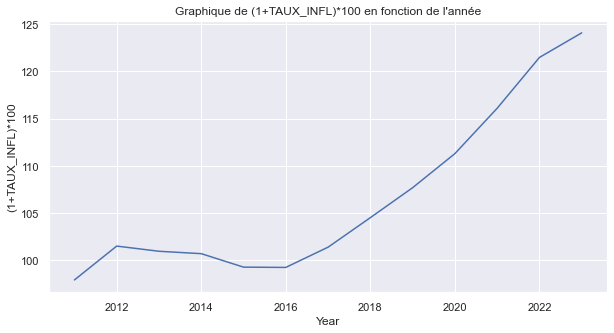

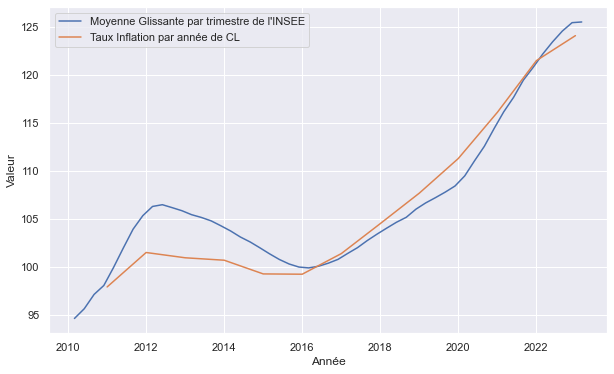

In [23]:
# Obtenir l'année actuelle

# TODO : Insérer le graphique dans le latex : chemin de l'image 'N:\uflujek\indicateur_marche\image\ens_idf'


current_year = datetime.now().year

liste_depts = ['92', '93', '94', '95', '91', '78', '77']
dept_str = ', '.join(f"'{dept}'" for dept in liste_depts)
requete_sql = f"""
SELECT DISTINCT *
FROM df_ti_dept_all
WHERE DEPT IN ({dept_str})"""
df_ti_dept = ps.sqldf(requete_sql, locals())

# Transformer 'P-1', 'P-2', etc. en années
df_ti_dept['Year'] = df_ti_dept['PERIODE'].apply(lambda x: current_year - int(x.split('-')[1]))

new_data = pd.DataFrame([{'Year': 2023, 'TAUX_INFL': 0}])

df_ti_dept_grouped = df_ti_dept.groupby('Year').agg({'TAUX_INFL': 'mean'}).reset_index()
df_ti_dept_grouped = pd.concat([ df_ti_dept_grouped, new_data], ignore_index=True)


df_ti_dept_grouped['Year'] = pd.to_datetime(df_ti_dept_grouped['Year'].astype(str), format='%Y')

df_ti_dept_grouped['TAUX_INFL_2023'] = (100/(1+df_ti_dept_grouped['TAUX_INFL']))

taux_infl_2015_2014 = df_ti_dept_grouped[df_ti_dept_grouped['Year'].dt.year.isin([2015, 2014])]['TAUX_INFL_2023'].mean()

df_ti_dept_grouped['TAUX_INFL_2015'] = (df_ti_dept_grouped['TAUX_INFL_2023']/taux_infl_2015_2014)*100

# Tracer le graphique
plt.figure(figsize=(10, 5))
plt.plot(df_ti_dept_grouped['Year'], df_ti_dept_grouped['TAUX_INFL_2015'])
plt.xlabel('Year')
plt.ylabel('(1+TAUX_INFL)*100')
plt.title('Graphique de (1+TAUX_INFL)*100 en fonction de l\'année')
plt.grid(True)



df = pd.read_csv(r'N:\uflujek\table_rapport\Indice_prix\valeurs_trimestrielles_idf_dept.csv', sep=';', encoding='latin1' ) 
df = df.rename(columns={df.columns[0]: 'Période'})
df = df.rename(columns={df.columns[1]: 'taux_infl'})
df['Période'] = df['Période'].astype(str)
df['Year'] = df['Période'].apply(lambda x: int(x.split('-')[0]))
df['Quarter'] = df['Période'].apply(lambda x: int(x.split('T')[-1]))
df['taux_infl'] = df['taux_infl'].astype(float)

df['Month'] = df['Quarter'] * 3

df['Période'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))


df_grouped = df.groupby('Période').agg({'taux_infl': 'mean'}).reset_index()
df_grouped['Moyenne Glissante'] = df_grouped['taux_infl'].rolling(window=4, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(df_grouped['Période'], df_grouped['Moyenne Glissante'], label="Moyenne Glissante par trimestre de l'INSEE")

plt.plot(df_ti_dept_grouped['Year'], df_ti_dept_grouped['TAUX_INFL_2015'], label='Taux Inflation par année de CL')

plt.xlabel('Année')
plt.ylabel('Valeur')
plt.legend()
plt.savefig(rf"N:\uflujek\indicateur_marche\image\ens_idf")

### Province 

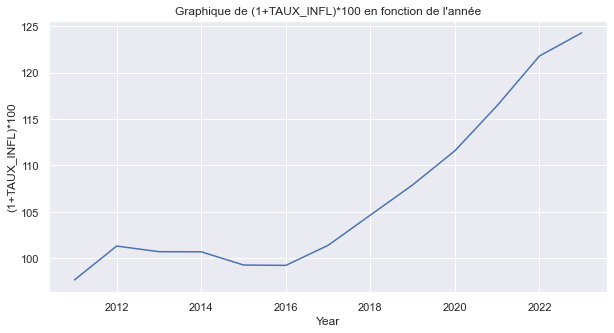

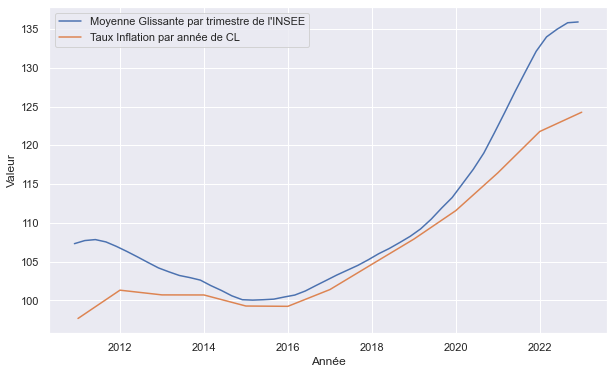

In [24]:
####################### Graphique de province ############################

# TODO : Insérer le graphique dans le latex section province: chemin graph "N:\uflujek\indicateur_marche\image\ens_province"

df_dept = pd.read_excel(r'N:\uflujek\table_rapport\Indice_prix\departements-francais.xlsx', header=2)
df_dept = df_dept.rename(columns={'Département\nNuméro': 'num_dpt'})
df_dept = df_dept.rename(columns={'Département\nNom': 'nom_dpt'})

df_ti_dept['DEPT'] = df_ti_dept['DEPT'].astype(str)
df_dept['num_dpt'] = df_dept['num_dpt'].astype(str)

# Ajoutez un '0' devant les numéros de départements de longueur 1 dans df_dept
df_dept['num_dpt'] = df_dept['num_dpt'].apply(lambda x: '0' + x if len(x) == 1 else x)



df_dept = df_dept.rename(columns={df_dept.columns[-2]: 'population'})

df_ti_dept = pd.merge(df_ti_dept, df_dept, left_on='DEPT', right_on='num_dpt', how='inner')


df_ti_dept['Year'] = df_ti_dept['PERIODE'].apply(lambda x: current_year - int(x.split('-')[1]))


df_ti_dept['TAUX_INFL'] =df_ti_dept['TAUX_INFL'].astype(float)
df_ti_dept['population'] =df_ti_dept['population'].astype(float)
df_ti_dept['TAUX_INFL_POP'] = df_ti_dept.apply(lambda row: row['TAUX_INFL'] * row['population'], axis=1)

df_ti_dept_grouped = df_ti_dept.groupby('Year').agg({'TAUX_INFL_POP': 'sum', 'population': 'sum'}).reset_index()
df_ti_dept_grouped['TAUX_INFL'] = df_ti_dept_grouped['TAUX_INFL_POP'] / df_ti_dept_grouped['population']
df_ti_dept_grouped = df_ti_dept_grouped.drop(columns=['TAUX_INFL_POP'])


new_data = pd.DataFrame([{'Year': 2023, 'TAUX_INFL': 0}])
df_ti_dept_grouped = pd.concat([df_ti_dept_grouped, new_data], ignore_index=True)

df_ti_dept_grouped['Year'] = pd.to_datetime(df_ti_dept_grouped['Year'].astype(str), format='%Y')

df_ti_dept_grouped['TAUX_INFL_2023'] = (100/(1+df_ti_dept_grouped['TAUX_INFL']))

taux_infl_2015_2014 = df_ti_dept_grouped[df_ti_dept_grouped['Year'].dt.year.isin([2015, 2014])]['TAUX_INFL_2023'].mean()

df_ti_dept_grouped['TAUX_INFL_2015'] = (df_ti_dept_grouped['TAUX_INFL_2023']/taux_infl_2015_2014)*100


# Tracer le graphique
plt.figure(figsize=(10, 5))
plt.plot(df_ti_dept_grouped['Year'], df_ti_dept_grouped['TAUX_INFL_2015'])
plt.xlabel('Year')
plt.ylabel('(1+TAUX_INFL)*100')
plt.title('Graphique de (1+TAUX_INFL)*100 en fonction de l\'année')
plt.grid(True)
plt.show()


df= pd.read_csv(rf'N:\uflujek\table_rapport\Indice_prix\valeurs_trimestrielles_province.csv', sep = ';')
df=df[4:]
df = df.rename(columns={df.columns[1]: 'taux_infl'})
df['taux_infl'] = df['taux_infl'].astype(float)
df['Year'] = df['Libellé'].apply(lambda x: int(x.split('-')[0]))
df['Quarter'] = df['Libellé'].apply(lambda x: int(x.split('T')[-1]))


df['Month'] = df['Quarter'] * 3

df['Période'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

df['Moyenne Glissante'] = df['taux_infl'].rolling(window=4, min_periods=1).mean()


plt.figure(figsize=(10, 6))
plt.plot(df['Période'], df['Moyenne Glissante'], label="Moyenne Glissante par trimestre de l'INSEE")
plt.plot(df_ti_dept_grouped['Year'], df_ti_dept_grouped['TAUX_INFL_2015'], label='Taux Inflation par année de CL')

plt.xlabel('Année')
plt.ylabel('Valeur')
plt.legend()
plt.savefig(rf"N:\uflujek\indicateur_marche\image\ens_province")

## Évolution de l'indice des prix de l'immobilier à l'échelle des régions

#### Tableau récapitulatif

In [25]:
############################### nom des régions ###################################
df = pd.read_csv(r'N:\uflujek\table_rapport\Indice_prix\regions_departements.csv')

header_df = pd.DataFrame([['index', 'ancienne Région', 'index_2', 'nouvelle région', 'département']], 
                         columns=df.columns)
df = pd.concat([header_df, df]).reset_index(drop=True)
df.columns = df.iloc[0]
df = df[1:]
df = df[['nouvelle région', 'département']]


df_dept = pd.read_excel(r'N:\uflujek\table_rapport\Indice_prix\departements-francais.xlsx', header=2)
df_dept = df_dept.rename(columns={'Département\nNuméro': 'num_dpt'})
df_dept = df_dept.rename(columns={'Département\nNom': 'nom_dpt'})
df_dept['num_dpt'] = df_dept['num_dpt'].astype(str)
df_dept['num_dpt'] = df_dept['num_dpt'].apply(lambda x: '0' + x if len(x) == 1 else x)


df['département'] = df['département'].astype(str)
df_dept['nom_dpt'] = df_dept['nom_dpt'].astype(str)
final_df = pd.merge(df_dept, df, left_on='nom_dpt', right_on='département', how='inner')

final_df = final_df[['nouvelle région', 'département', 'num_dpt']]


filtered_df = final_df[final_df['nouvelle région'].isin(regions_interested)]

# Grouper les données par région et récupérer les départements dans des listes
result = filtered_df.groupby('nouvelle région')['num_dpt'].apply(list)
final_result = [list(group) for group in result]

print(final_result)

[['59', '62'], ['04', '05', '06', '13', '83', '84'], ['01', '07', '26', '38', '42', '69', '73', '74']]


In [26]:
# TODO : Évolution des indices des prix selon CL par région : resultats_finaux


cd_type = 'APT'
resultats_finaux = pd.DataFrame(columns=['Région', '10 ans', '8 ans', '5 ans', '1 an'])

# Itérer sur chaque région et ses départements
for region, liste_departements in zip(regions_interested, final_result):

    df_resultats = pd.DataFrame()

    for num_dept in liste_departements:
        requete_sql = f"""
        SELECT DISTINCT *
        FROM df_ti_dept_all
        WHERE DEPT = {num_dept} AND CD_TYP_BIEN = '{cd_type}'"""
        df_ti_dept = ps.sqldf(requete_sql, locals())

        df_ti_dept['Year'] = df_ti_dept['PERIODE'].apply(lambda x: current_year - int(x.split('-')[1]))

        new_data = pd.DataFrame([{'Year': 2023, 'TAUX_INFL': 0}])
        df_ti_dept = pd.concat([new_data, df_ti_dept], ignore_index=True)
        df_ti_dept['Year'] = pd.to_datetime(df_ti_dept['Year'].astype(str), format='%Y')
        df_ti_dept['TAUX_INFL_2023'] = 100/(1+df_ti_dept['TAUX_INFL'])

        taux_infl_2015_2014 = df_ti_dept[df_ti_dept['Year'].dt.year.isin([2015, 2014])]['TAUX_INFL_2023'].mean()
        df_ti_dept['TAUX_INFL_2015'] = (df_ti_dept['TAUX_INFL_2023']/taux_infl_2015_2014)*100

        taux_infl_2023 = df_ti_dept[df_ti_dept['Year'].dt.year.isin([2023])]['TAUX_INFL_2015'].iloc[0]
        df_ti_dept['TAUX_INFL_FINAL'] = ((taux_infl_2023/df_ti_dept['TAUX_INFL_2015'])-1)*100

        df_resultats = pd.concat([df_resultats, df_ti_dept[['Year', 'TAUX_INFL_FINAL']]], ignore_index=True)


    moyenne_par_annee = df_resultats.groupby(df_resultats['Year'].dt.year)['TAUX_INFL_FINAL'].mean().reset_index()

    dix_ans = moyenne_par_annee[moyenne_par_annee['Year'].between(current_year - 10, current_year)]['TAUX_INFL_FINAL'].mean()
    huit_ans = moyenne_par_annee[moyenne_par_annee['Year'].between(current_year - 8, current_year)]['TAUX_INFL_FINAL'].mean()
    cinq_ans = moyenne_par_annee[moyenne_par_annee['Year'].between(current_year - 5, current_year)]['TAUX_INFL_FINAL'].mean()
    un_an = moyenne_par_annee[moyenne_par_annee['Year'].between(current_year - 1, current_year)]['TAUX_INFL_FINAL'].mean()

    resultats_finaux = resultats_finaux.append({
        'Région': region,
        '10 ans': f'+{dix_ans:.2f}',
        '8 ans': f'+{huit_ans:.2f}',
        '5 ans': f'+{cinq_ans:.2f}',
        '1 an': f'+{un_an:.2f}'}, ignore_index=True)

resultats_finaux



,Région,10 ans,8 ans,5 ans,1 an
0,Nord-Pas-de-Calais,+10.03,+8.62,+6.71,+1.95
1,Provence-Alpes-Côte-d'Azur,+18.19,+18.38,+16.33,+4.50
2,Rhône-Alpes,+22.60,+22.01,+17.18,+4.57


In [27]:
# TODO : Évolution des indices des prix selon INSEE : df_resultat


def get_percentage_changes(region_name):
    chemin = f'N:\\uflujek\\table_rapport\\Indice_prix\\valeurs_trimestrielles_{region_name}.csv'
    df = pd.read_csv(chemin, sep=';')
    df = df.rename(columns={df.columns[0]: 'Période', df.columns[1]: 'Valeur'})
    df = df.iloc[3:, :]
    df['Valeur'] = df['Valeur'].astype(float)
    année_actuelle = int(df.iloc[0]['Période'].split('-')[0])

    un_an = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-1}-T1', 'Valeur'].values[0] - 1).round(4)
    cinq_ans = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-5}-T1', 'Valeur'].values[0] - 1).round(4)
    huit_ans = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-8}-T1', 'Valeur'].values[0] - 1).round(4)
    dix_ans = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-10}-T1', 'Valeur'].values[0] - 1).round(4)
    
    return [dix_ans * 100, huit_ans * 100, cinq_ans * 100, un_an * 100]

resultat = {'Région': [], '10 ans': [], '8 ans': [], '5 ans': [], '1 an': []}

for region in regions_interested:
    changes = get_percentage_changes(region)
    resultat['Région'].append(region)
    resultat['10 ans'].append(format_change(changes[0]))
    resultat['8 ans'].append(format_change(changes[1]))
    resultat['5 ans'].append(format_change(changes[2]))
    resultat['1 an'].append(format_change(changes[3]))

df_resultat = pd.DataFrame(resultat)
print(df_resultat)



                       Région  10 ans   8 ans   5 ans   1 an
0          Nord-Pas-de-Calais  +21.87  +26.75  +23.17  +1.77
1  Provence-Alpes-Côte-d'Azur  +22.66  +31.21  +26.12  +5.78
2                 Rhône-Alpes  +36.42  +39.86   +32.0  +3.28


#### Graphiques

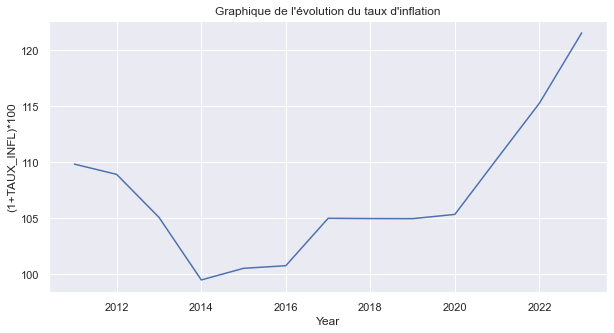

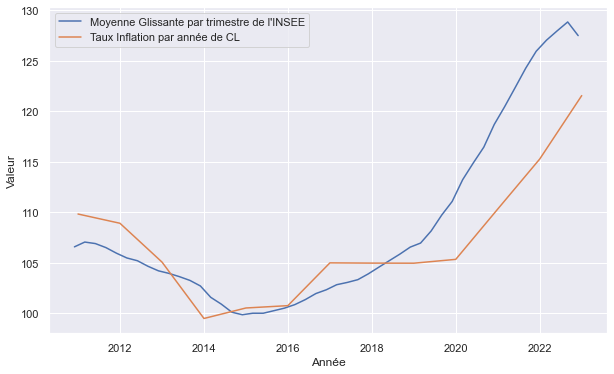

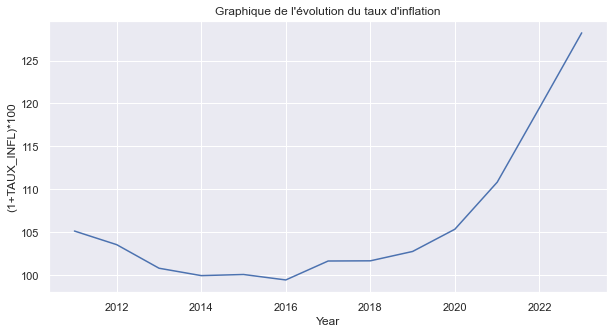

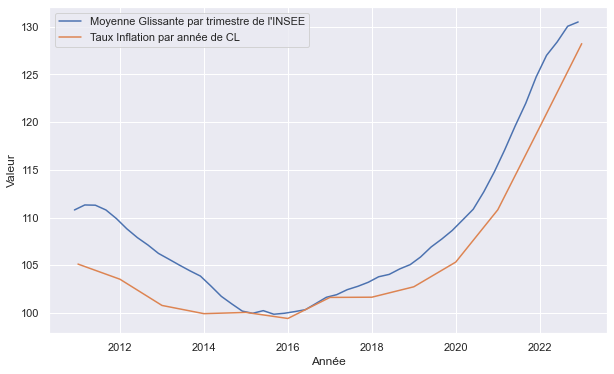

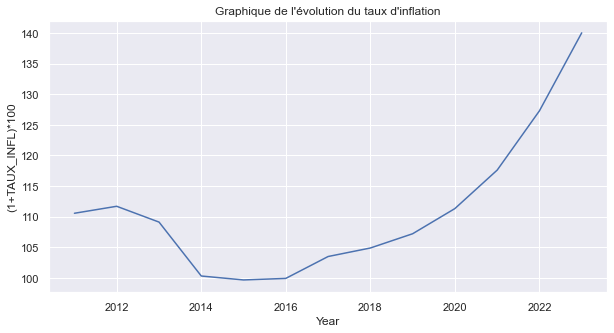

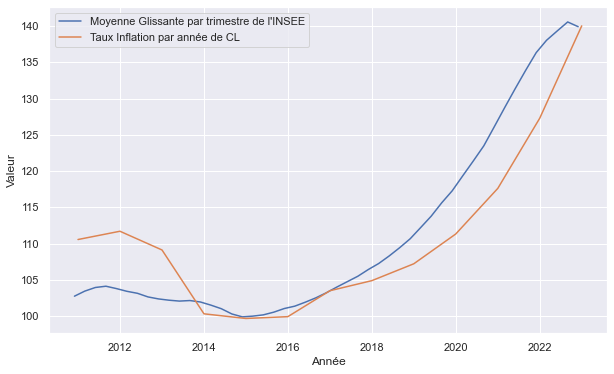

In [28]:
# TODO : insérer les graphiques dans le latex, les images sont aux chemins : f"N:\uflujek\indicateur_marche\image\{nom_region}"


index = 0
for liste_depts in final_result:
    nom_region = regions_interested[index]
    index += 1
    dept_str = ', '.join(f"'{dept}'" for dept in liste_depts)
    requete_sql = f"""
    SELECT DISTINCT *
    FROM df_ti_dept_all
    WHERE DEPT IN ({dept_str})"""
    df_ti_dept = ps.sqldf(requete_sql, locals())


    df_dept = pd.read_excel(r'N:\uflujek\table_rapport\Indice_prix\departements-francais.xlsx', header=2)
    df_dept = df_dept.rename(columns={'Département\nNuméro': 'num_dpt'})
    df_dept = df_dept.rename(columns={'Département\nNom': 'nom_dpt'})

    df_ti_dept['DEPT'] = df_ti_dept['DEPT'].astype(str)
    df_dept['num_dpt'] = df_dept['num_dpt'].astype(str)

    # Ajoutez un '0' devant les numéros de départements de longueur 1 dans df_dept
    df_dept['num_dpt'] = df_dept['num_dpt'].apply(lambda x: '0' + x if len(x) == 1 else x)

    # Fusionnez les dataframes
    df_ti_dept = pd.merge(df_ti_dept, df_dept, left_on='DEPT', right_on='num_dpt', how='inner')
    df_ti_dept= df_ti_dept.rename(columns={df_ti_dept.columns[-2]: 'population'})


    # Transformer 'P-1', 'P-2', etc. en années
    df_ti_dept['Year'] = df_ti_dept['PERIODE'].apply(lambda x: current_year - int(x.split('-')[1]))


    df_ti_dept['TAUX_INFL_POP'] = df_ti_dept['TAUX_INFL'] * df_ti_dept['population']
    df_ti_dept_grouped = df_ti_dept.groupby('Year').agg({'TAUX_INFL_POP': 'sum', 'population': 'sum'}).reset_index()
    df_ti_dept_grouped['TAUX_INFL'] = df_ti_dept_grouped['TAUX_INFL_POP'] / df_ti_dept_grouped['population']
    df_ti_dept_grouped = df_ti_dept_grouped.drop(columns=['TAUX_INFL_POP'])


    new_data = pd.DataFrame([{'Year': 2023, 'TAUX_INFL': 0}])
    df_ti_dept_grouped = pd.concat([df_ti_dept_grouped, new_data], ignore_index=True)

    df_ti_dept_grouped['Year'] = pd.to_datetime(df_ti_dept_grouped['Year'].astype(str), format='%Y')

    df_ti_dept_grouped['TAUX_INFL_2023'] = (100/(1+df_ti_dept_grouped['TAUX_INFL']))

    taux_infl_2015_2014 = df_ti_dept_grouped[df_ti_dept_grouped['Year'].dt.year.isin([2015, 2014])]['TAUX_INFL_2023'].mean()

    df_ti_dept_grouped['TAUX_INFL_2015'] = (df_ti_dept_grouped['TAUX_INFL_2023']/taux_infl_2015_2014)*100


    # Tracer le graphique
    plt.figure(figsize=(10, 5))
    plt.plot(df_ti_dept_grouped['Year'], df_ti_dept_grouped['TAUX_INFL_2015'])
    plt.xlabel('Year')
    plt.ylabel('(1+TAUX_INFL)*100')
    plt.title("Graphique de l'évolution du taux d'inflation")
    plt.grid(True)
    plt.show()


    df= pd.read_csv(rf'N:\uflujek\table_rapport\Indice_prix\valeurs_trimestrielles_{nom_region}.csv', sep = ';')
    df=df[4:]
    df = df.rename(columns={df.columns[1]: 'taux_infl'})
    df['taux_infl'] = df['taux_infl'].astype(float)
    df['Year'] = df['Libellé'].apply(lambda x: int(x.split('-')[0]))
    df['Quarter'] = df['Libellé'].apply(lambda x: int(x.split('T')[-1]))


    df['Month'] = df['Quarter'] * 3

    df['Période'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

    df['Moyenne Glissante'] = df['taux_infl'].rolling(window=4, min_periods=1).mean()

    # Tracer la moyenne glissante
    plt.figure(figsize=(10, 6))
    plt.plot(df['Période'], df['Moyenne Glissante'], label="Moyenne Glissante par trimestre de l'INSEE")

    # Tracer le taux d'inflation
    plt.plot(df_ti_dept_grouped['Year'], df_ti_dept_grouped['TAUX_INFL_2015'], label='Taux Inflation par année de CL')

    plt.xlabel('Année')
    plt.ylabel('Valeur')
    plt.legend()
    plt.savefig(rf"N:\uflujek\indicateur_marche\image\{nom_region}")

## Évolution de l'indice des prix de l'immobilier à l'échelle des villes

In [29]:
############################################# IMPORT ###########################################
SERVEUR = 'ISIS'
DATABASE = 'BIENS'
SCHEMA = 'dbo'




PROD_PWD = 'Est1mat1on@b1ens_Dev%'
PROD_ID = 'Ebiens_Batch'




conn = pyodbc.connect('DRIVER={SQL Server};'
                                f'SERVER={SERVEUR};'
                                f'DATABASE={DATABASE};'
                                f'UID={PROD_ID};'
                                f'PWD={PROD_PWD};')
df_ti_ville_all = pd.read_sql_query(
    f"""SELECT DISTINCT *
    FROM BIENS.dbo.TI_VILLE""" 
    ,conn)
df_ti_ville_all

,ID,REF,TAUX_INFL,EFFECTIF,TAUX_INFL_DIFF,PERIODE,CD_TYP_BIEN,VILLE,PERIODE_REF_MIN,PERIODE_REF_MAX
0,1,0001_APT_ABLON SUR SEINE,0.0486,39,0.1651,P-1,APT,ABLON SUR SEINE,2022-08-01,2023-08-01
1,2,0001_APT_ACHERES,0.0544,87,0.0348,P-1,APT,ACHERES,2022-08-01,2023-08-01
2,3,0001_APT_AGDE,0.1050,717,0.0336,P-1,APT,AGDE,2022-08-01,2023-08-01
3,4,0001_APT_AGEN,0.0752,141,0.1178,P-1,APT,AGEN,2022-08-01,2023-08-01
4,5,0001_APT_AIME PLAGNE,0.1856,86,0.1853,P-1,APT,AIME PLAGNE,2022-08-01,2023-08-01
...,...,...,...,...,...,...,...,...,...,...
19489,19490,0012_MAI_MARSEILLE,0.3557,69,0.3080,P-12,MAI,MARSEILLE,2022-08-01,2023-08-01
19490,19491,0012_MAI_NANTES,0.8935,70,0.1305,P-12,MAI,NANTES,2022-08-01,2023-08-01
19491,19492,0012_MAI_SAINT MAUR FOSSES,0.6303,31,0.0734,P-12,MAI,SAINT MAUR FOSSES,2022-08-01,2023-08-01
19492,19493,0012_MAI_TOULOUSE,0.3929,61,0.2854,P-12,MAI,TOULOUSE,2022-08-01,2023-08-01


### Tableau récapitulatif

In [30]:
# TODO : Évolution de l'indice des prix selon CL pour les villes: final_df

annees_cibles = [10, 8, 5, 1]
current_year = datetime.now().year


final_data= []
# Dictionnaire pour stocker les résultats
resultats = {ville: {} for ville in villes}

for ville in villes:
    requete_sql = f"""
    SELECT DISTINCT *
    FROM df_ti_ville_all
    WHERE VILLE = '{ville}' AND CD_TYP_BIEN = 'APT' """
    df_ti_ville = ps.sqldf(requete_sql, locals())
    
    df_ti_ville['Year'] = df_ti_ville['PERIODE'].apply(lambda x: current_year - int(x.split('-')[1]))


    new_data = pd.DataFrame([{'Year': 2023, 'TAUX_INFL': 0}])
    df_ti_ville = pd.concat([new_data, df_ti_ville], ignore_index=True)

    df_ti_ville['Year'] = pd.to_datetime(df_ti_ville['Year'].astype(str), format='%Y')

    df_ti_ville['TAUX_INFL_2023'] = 100/(1+df_ti_ville['TAUX_INFL'])

    taux_infl_2015_2014 =df_ti_ville[df_ti_ville['Year'].dt.year.isin([2015, 2014])]['TAUX_INFL_2023'].mean()

    df_ti_ville['TAUX_INFL_2015'] = (df_ti_ville['TAUX_INFL_2023']/taux_infl_2015_2014)*100

    taux_infl_2023 =df_ti_ville[df_ti_ville['Year'].dt.year.isin([2023])]['TAUX_INFL_2015'].iloc[0]
    df_ti_ville['TAUX_INFL_FINAL'] = ((taux_infl_2023/df_ti_ville['TAUX_INFL_2015'])-1)*100
    taux_10_ans = df_ti_ville.loc[df_ti_ville['Year'].dt.year == current_year - 10, 'TAUX_INFL_FINAL'].iloc[0]
    taux_8_ans = df_ti_ville.loc[df_ti_ville['Year'].dt.year == current_year - 8, 'TAUX_INFL_FINAL'].iloc[0]
    taux_5_ans = df_ti_ville.loc[df_ti_ville['Year'].dt.year == current_year - 5, 'TAUX_INFL_FINAL'].iloc[0]
    taux_1_an = df_ti_ville.loc[df_ti_ville['Year'].dt.year == current_year - 1, 'TAUX_INFL_FINAL'].iloc[0]


    final_data.append({
        'Ville': ville.capitalize(),
        '10 ans': taux_10_ans,
        '8 ans': taux_8_ans,
        '5 ans': taux_5_ans,
        '1 an': taux_1_an
    })
final_df = pd.DataFrame(final_data)

# Affichez le DataFrame
print(final_df)

       Ville  10 ans  8 ans  5 ans   1 an
0      Paris   28.54  32.81  14.42  -1.53
1  Marseille   22.96  36.30  36.79  13.85
2       Lyon   30.57  51.93  26.35   0.76
3      Lille   25.78  35.96  24.02   4.94


In [31]:
# TODO : Évolution de l'indice des prix selon INSEE pour les villes: df_resultat_villes


def get_percentage_changes(file_name):
    chemin = f'N:\\uflujek\\table_rapport\\Indice_prix\\valeurs_trimestrielles_{file_name}.csv'
    df = pd.read_csv(chemin, sep=';')
    df = df.rename(columns={df.columns[0]: 'Période', df.columns[1]: 'Valeur'})
    df = df.iloc[3:, :]
    df['Valeur'] = pd.to_numeric(df['Valeur'], errors='coerce')
    année_actuelle = int(df.iloc[0]['Période'].split('-')[0])

    un_an = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-1}-T1', 'Valeur'].values[0] - 1).round(4)
    cinq_ans = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-5}-T1', 'Valeur'].values[0] - 1).round(4)
    huit_ans = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-8}-T1', 'Valeur'].values[0] - 1).round(4)
    dix_ans = (df.loc[df['Période'] == f'{année_actuelle}-T1', 'Valeur'].values[0] / df.loc[df['Période'] == f'{année_actuelle-10}-T1', 'Valeur'].values[0] - 1).round(4)
    
    return [dix_ans * 100, huit_ans * 100, cinq_ans * 100, un_an * 100]

resultat = {'Ville': [], '10 ans': [], '8 ans': [], '5 ans': [], '1 an': []}

for ville, type_bien in zip(villes, types_biens):
    file_name = f"{type_bien}_{ville}"
    changes = get_percentage_changes(file_name)
    resultat['Ville'].append(ville.capitalize())
    resultat['10 ans'].append(format_change(changes[0]))
    resultat['8 ans'].append(format_change(changes[1]))
    resultat['5 ans'].append(format_change(changes[2]))
    resultat['1 an'].append(format_change(changes[3]))

df_resultat_villes = pd.DataFrame(resultat)
print(df_resultat_villes)


       Ville  10 ans   8 ans   5 ans   1 an
0      Paris  +24.38  +30.25  +13.39  -2.04
1  Marseille  +25.34   +38.8  +32.24  +6.53
2       Lyon  +51.57  +50.05  +29.64   -1.9
3      Lille  +29.18   +30.6  +25.46  -0.23


### Graphiques

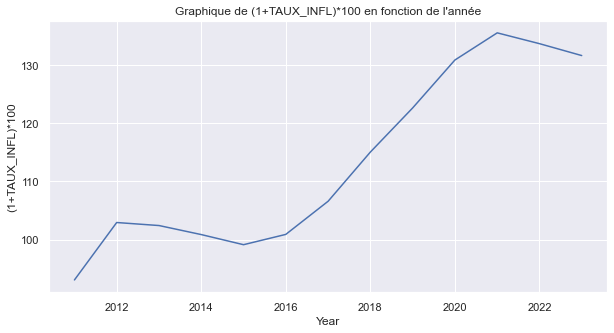

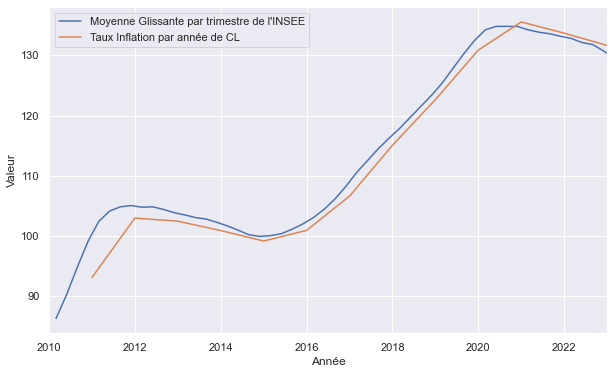

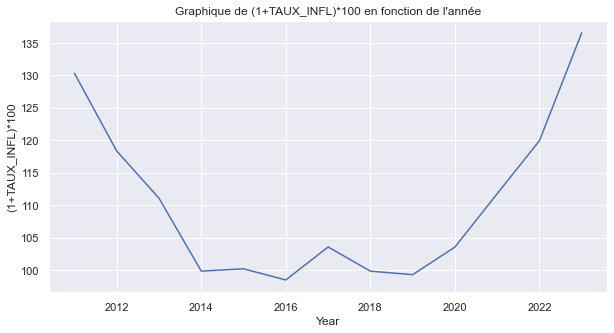

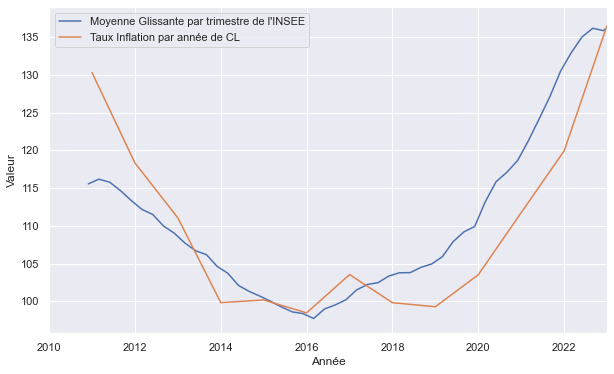

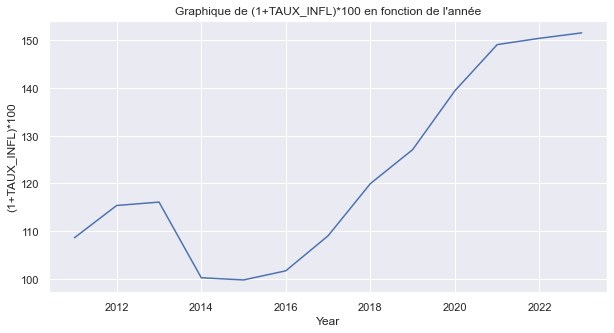

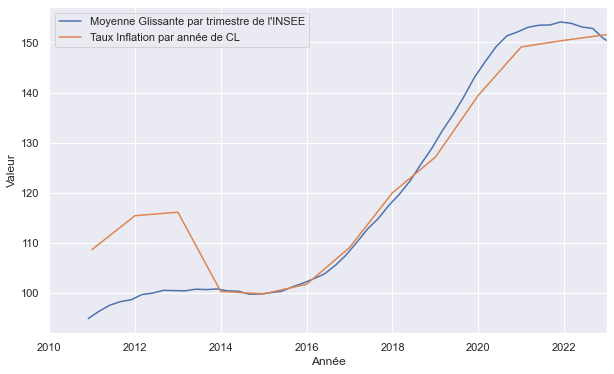

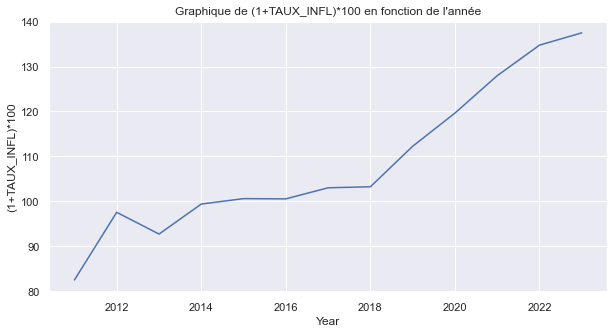

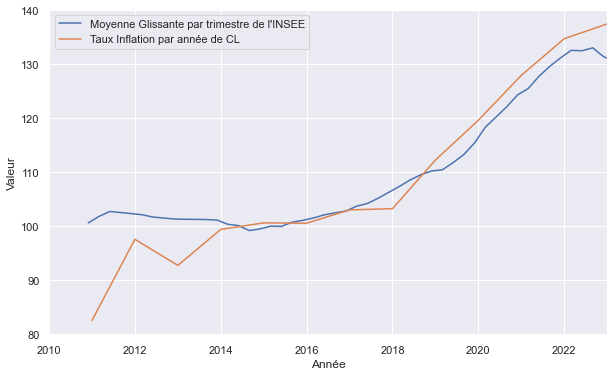

In [32]:
# TODO : Insérer les graphiques dans le latex : chemin des images : N:\uflujek\indicateur_marche\image\{cd_type}_{ville}



# Obtenir l'année actuelle
current_year = datetime.now().year
for ville, cd_type in zip(villes, types_biens):

    requete_sql = f"""
    SELECT DISTINCT *
    FROM df_ti_ville_all
    WHERE VILLE = '{ville}' AND CD_TYP_BIEN = '{cd_type}' """
    df_ti_ville= ps.sqldf(requete_sql, locals())
    # Transformer 'P-1', 'P-2', etc. en années
    df_ti_ville['Year'] = df_ti_ville['PERIODE'].apply(lambda x: current_year - int(x.split('-')[1]))

    new_data = pd.DataFrame([{'Year': 2023, 'TAUX_INFL': 0}])
    df_ti_ville = pd.concat([new_data, df_ti_ville], ignore_index=True)

    df_ti_ville['Year'] = pd.to_datetime(df_ti_ville['Year'].astype(str), format='%Y')



    df_ti_ville['TAUX_INFL_2023'] = 100/(1+df_ti_ville['TAUX_INFL'])

    taux_infl_2015_2014 =df_ti_ville[df_ti_ville['Year'].dt.year.isin([2015, 2014])]['TAUX_INFL_2023'].mean()

    df_ti_ville['TAUX_INFL_2015'] = (df_ti_ville['TAUX_INFL_2023']/taux_infl_2015_2014)*100

    # Tracer le graphique
    plt.figure(figsize=(10, 5))
    plt.plot(df_ti_ville['Year'],df_ti_ville['TAUX_INFL_2015'])
    plt.xlabel('Year')
    plt.ylabel('(1+TAUX_INFL)*100')
    plt.title('Graphique de (1+TAUX_INFL)*100 en fonction de l\'année')
    plt.grid(True)
    plt.show()

    df= pd.read_csv(rf'N:\uflujek\table_rapport\Indice_prix\valeurs_trimestrielles_{cd_type}_{ville}.csv', sep = ';')
    df=df[3:]
    df = df.rename(columns={df.columns[1]: 'taux_infl'})
    df['taux_infl'] = df['taux_infl'].replace('(s)', np.nan)
    df['taux_infl'] = df['taux_infl'].astype(float)

    df['Year'] = df['Libellé'].apply(lambda x: int(x.split('-')[0]))
    df['Quarter'] = df['Libellé'].apply(lambda x: int(x.split('T')[-1]))


    df['Month'] = df['Quarter'] * 3

    df['Période'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

    df['Moyenne Glissante'] = df['taux_infl'].rolling(window=4, min_periods=1).mean()



    start_year = min(df['Période'].min().year, df_ti_ville['Year'].min().year)
    end_year = max(df['Période'].max().year, df_ti_ville['Year'].max().year)
    plt.figure(figsize=(10, 6))
    plt.plot(df['Période'], df['Moyenne Glissante'].astype(float), label="Moyenne Glissante par trimestre de l'INSEE")

    # Tracer le taux d'inflation
    plt.plot(df_ti_ville['Year'], df_ti_ville['TAUX_INFL_2015'], label='Taux Inflation par année de CL')

    plt.xlabel('Année')
    plt.ylabel('Valeur')
    plt.legend()

    plt.xlim(pd.to_datetime(start_year, format='%Y'), pd.to_datetime(end_year, format='%Y'))
    plt.savefig(rf"N:\uflujek\indicateur_marche\image\{cd_type}_{ville}")

### Tableaux par arrondissements

In [33]:
############################################# IMPORT ##############################################################
SERVEUR = 'ISIS'
DATABASE = 'BIENS'
SCHEMA = 'dbo'




PROD_PWD = 'Est1mat1on@b1ens_Dev%'
PROD_ID = 'Ebiens_Batch'




conn = pyodbc.connect('DRIVER={SQL Server};'
                                f'SERVER={SERVEUR};'
                                f'DATABASE={DATABASE};'
                                f'UID={PROD_ID};'
                                f'PWD={PROD_PWD};')
df_ti_arr_all = pd.read_sql_query(
    f"""SELECT DISTINCT *
    FROM BIENS.dbo.TI_ARR""" 
    ,conn)
print(df_ti_arr_all)
df_ti_arr_all['CD_POSTAL'] = df_ti_arr_all['CD_POSTAL'].astype(str)
df_ti_arr_all = df_ti_arr_all[df_ti_arr_all['CD_POSTAL'].str.startswith(('690', '750', '130'))]


          ID             REF  TAUX_INFL  EFFECTIF  TAUX_INFL_DIFF PERIODE  \
0          1  0001_APT_01000     0.0748       109          0.1078     P-1   
1          2  0001_APT_01100     0.0844        32          0.1832     P-1   
2          3  0001_APT_01120    -0.0146        27          0.2405     P-1   
3          4  0001_APT_01170     0.1135       118          0.0435     P-1   
4          5  0001_APT_01200     0.2171        38          0.1365     P-1   
...      ...             ...        ...       ...             ...     ...   
48034  48035  0012_MAI_95300     0.2466        18          0.4942    P-12   
48035  48036  0012_MAI_95320     0.4336        17          0.2859    P-12   
48036  48037  0012_MAI_95400     0.3280        26          0.2805    P-12   
48037  48038  0012_MAI_95520     0.4926        19          0.3916    P-12   
48038  48039  0012_MAI_98800     0.0025        17          0.0798    P-12   

      CD_TYP_BIEN CD_POSTAL PERIODE_REF_MIN PERIODE_REF_MAX  
0            

In [34]:
# TODO : insérer les tableaux par arrondissements : summary_69, summary_75, summary_13

def compute_summary_table(df, current_year):
    df_ti_ville_all = df.copy() 

    final_df = pd.DataFrame()

    postal_prefixes = df_ti_ville_all['CD_POSTAL'].apply(lambda x: x[:2]).unique()

    for postal_prefix in postal_prefixes:
        query = f"""
        SELECT DISTINCT *
        FROM df_ti_ville_all
        WHERE CD_POSTAL LIKE '{postal_prefix}%' AND CD_TYP_BIEN = 'APT'
        """
        df_ti_ville = ps.sqldf(query, locals())

        df_ti_ville['Année'] = df_ti_ville['PERIODE'].apply(lambda x: current_year - int(x.split('-')[1]))

        
        new_data = pd.DataFrame([{'Année': current_year, 'TAUX_INFL': 0}])
        df_ti_ville = pd.concat([new_data, df_ti_ville], ignore_index=True)
        df_ti_ville['Année'] = pd.to_datetime(df_ti_ville['Année'].astype(str), format='%Y')
        df_ti_ville['TAUX_INFL_2023'] = 100/(1+df_ti_ville['TAUX_INFL'])
        taux_infl_2015_2014 = df_ti_ville[df_ti_ville['Année'].dt.year.isin([2015, 2014])]['TAUX_INFL_2023'].mean()
        df_ti_ville['TAUX_INFL_2015'] = (df_ti_ville['TAUX_INFL_2023']/taux_infl_2015_2014)*100
        taux_infl_2023 = df_ti_ville[df_ti_ville['Année'].dt.year == current_year]['TAUX_INFL_2015'].iloc[0]
        df_ti_ville['TAUX_INFL_FINAL'] = ((taux_infl_2023/df_ti_ville['TAUX_INFL_2015'])-1)*100

        df_result = df_ti_ville.pivot_table(values='TAUX_INFL_FINAL', index=df_ti_ville['CD_POSTAL'].str[-2:], columns=current_year - df_ti_ville['Année'].dt.year)
        df_result = df_result[[10, 8, 5, 1]].add_suffix(' ans')
        df_result.index.name = 'Arrondissement'
        df_result = df_result.reset_index()
        final_df = pd.concat([final_df, df_result])
    final_df.columns.name = None


    return final_df

current_year = datetime.now().year
df_ti_arr_690 = df_ti_arr_all[df_ti_arr_all['CD_POSTAL'].str.startswith('690')]
df_ti_arr_750 = df_ti_arr_all[df_ti_arr_all['CD_POSTAL'].str.startswith('750')]
df_ti_arr_130 = df_ti_arr_all[df_ti_arr_all['CD_POSTAL'].str.startswith('130')]

dataframes = [df_ti_arr_690, df_ti_arr_130, df_ti_arr_750]

summary_69 = compute_summary_table(df_ti_arr_690, current_year)
summary_75 = compute_summary_table(df_ti_arr_750, current_year)
summary_13 = compute_summary_table(df_ti_arr_130, current_year)

print(summary_69)

  Arrondissement  10 ans  8 ans  5 ans  1 ans
0             01   45.97  59.85  27.65  -1.92
1             02   28.47  53.67  25.31  -4.07
2             03   52.85  54.84  34.20   0.81
3             04   50.83  58.02  27.16  -1.01
4             05   20.72  44.10  28.91   2.11
5             06   48.16  56.14  28.04   0.49
6             07   24.58  52.10  13.56   0.84
7             08   14.85  43.11  24.97   5.38
8             09   -3.95  47.54  34.67   2.46
